Deadlines:

Project report: 28.05.2023, 23:59

Presentation: 31.05.2023

General to-do list:

- [ ] keep track of the values of evaluation metrics (Excel spreadsheet)

- [ ] to go through TO-DO-s in the code and fix it

- [ ] documentation: leave comments in the notebook

- [ ] select the date to attend a coaching session + send an email to the tutors about it

- [ ] check out the 'helper' notebook here: https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem 

- [ ] Compare results with other notebooks

Code-related to-do list:

- [ ] add box plots for identifying outliers

- [ ] hyperparameter optimization (e.g. max depth in decision tree)

- [ ] cross-validation

- [ ] add cost matrix or think about other way to punish false negatives (e.g. look at medical scientific papers)

- [ ] add boosted trees (XGBoost
, GBM, LightGBM) https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

- [ ] search for some 'official' guidelines for diagnosing diabetes and comparing our best model logic to these guidelines. See: https://www.diabetes.org.uk/professionals/position-statements-reports/diagnosis-ongoing-management-monitoring/new_diagnostic_criteria_for_diabetes

- [ ] think about how to deal with medical features (e.g. glucose level, etc.): maybe binning/encoding (e.g. separate values for level which is normal, lower, higher than norm)

Normal : HbA1C (5.7%> x >6.5%), Blood Glucose (fasting) (99 > x > 126 mg/dL)t

- [ ] Clusters - Type 1 and Type 2 diabetes. We (the dataset) do not differentiate Type1 and Type2. We could try to build clusters and make assumptions/possible interpretations of which type the clusters could be

- [ ] understand the preprocessing in FastAI neural network and try it out for other models AND apply our own preprocessing to this neural network model

Structure of the notebook:

undefined. Exploratory Data Analysis

- data metrics

- distributions of attributes (maybe from the helper notebook, experiment with bin width)

- correlation? (what we would do with the result of correlation analysis? are we going to conduct feature relevance evaluation? by the way, in the report we could say that in case of a very high correlation we would consider to remove one of such features to avoid collinearity)

- box plots for identifying outliers (in the helper notebook) - maybe violin plots?

2. Preprocessing

- Handle missing values (probably exclude such entries. In the paper we could also discuss the approach with median/mean). If we don't exclude -> using univariate imputation (mean/median/mode) would be more appropriate than multivariate imputation (model feature 'smoking_history' as a function of other features - makes no sense for our dataset). In KNN -> check KNNImputer

- encoding (for the ’gender’ feature we will create a new attribute for every distinct value, while in case of the ’smoking history’ we might use the ordinal encoder - unlike gender, the heaviness of the smoking habit could be represented with ordinal values)

- Handle outliers. Mainly outlier in age -> we could omit it.

- normalisation (try both MinMaxScaler and StandardScaler) (e.g. using binning - see DM_Exercise_3, MinMaxScaler, please refer to exercise 02)

- Split data: train and test (balance training data) - use stratified c-v (https://www.kaggle.com/code/mohamedkhaled2007/diabetes-prediction-mkma-stack?scriptVersionId=125802796&cellId=21)

- balancing (DM_Ex_4) (The  approaches  we  consider  are:  to  use oversampling technique, to use under sampling, maybe combined approach, or stratified sampling in c-val)

3. Models

- Stratified cross-validation (DM_Ex_4)

- hyperparameter tuning (Grid search) (DM_Ex_5 provides a nice example of both hyper parameter tuning and cross-val)

- Logistic regression - https://www.kaggle.com/code/funxexcel/p2-logistic-regression-hyperparameter-tuning

- KNN - handling missing values with KNNImputer (mean of the K nearest neighbors)

- Naive-Bayes?

- Decision tree

- Random forests 

- XGBoost (maybe some others?)

- SVM

- Neural networks - https://www.kaggle.com/code/ishantgargml/diabetes-prediction-96-99-accuracy-ann (to justify the use of particular neural network types)

4. Evaluation

- Confusion matrix

- Accuracy, precision, recall

- ROC Curve + AUC (one graph with ROC curves for each model)

- cost-based evaluation (DM_Ex_5). Look up other data science projects/research papers on medical data - how do they assign weights. Which unit of measure?

- make a table summarising&comparing the results of all the estimators

- Log loss? (maybe there is no point because decision trees and random forests typically do not output class probabilities, and so log loss cannot be used with these models, ergo, we won't be able to compare them with other models using this metrics)

Questions:

- When we should and should not apply the same preprocessing to the test data, should we also apply balancing techniques? We were told not to touch the test data but in DM_Exercise_3 we read: "If we want to evaluate our model on a second dataset, we must take care to apply the same preprocessing as we did for the training"

- handling missing values: exclude -> use ordinal encoder or leave it as it is -> use one hot encoder

- could stratified c-val go in combination with oversampling

- could we do slightly different preprocessing for different estimators (e.g. we would do KNNImputer for KNN and a different technique for other estimators)?

# Exploratory Data Analysis

## Load data and glimpse at it

In [4]:
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import numpy as np

Helper function from exercise 5

In [5]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()


In [6]:
# Load dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")


### Univariate exploration

In [7]:
df.duplicated().sum()


3854

In [8]:
# show the first 5 rows
df.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [9]:
# show data types of the dataset
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [10]:
# show summary of the dataset
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


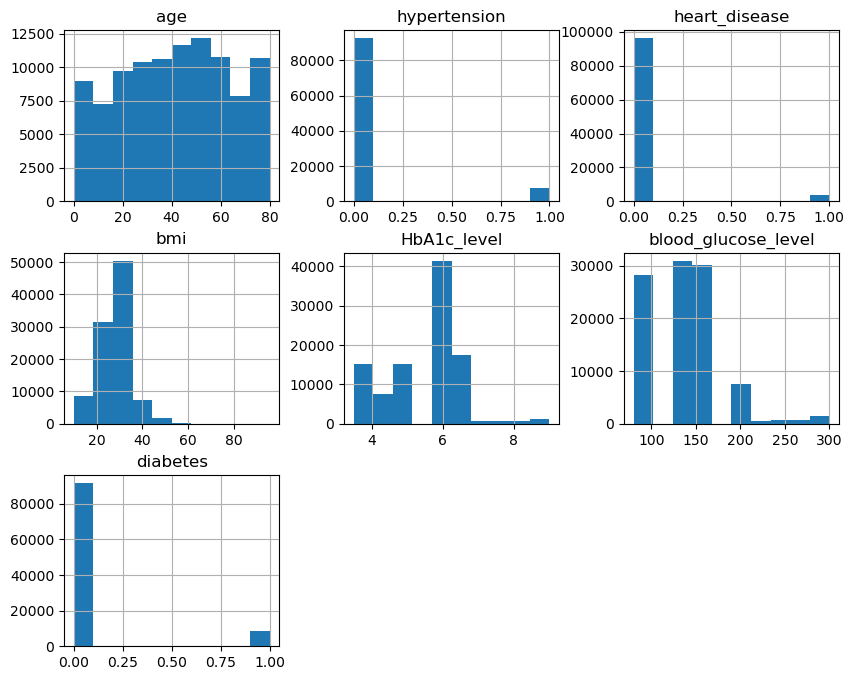

In [11]:
# show histogram of attributes (should we show this here or after encoding the gender?) // a

df.hist(figsize=(10, 8))
plt.show()

#### Identify Missing Values

In [12]:
missing_values_count = (
    df.isna().sum()
)  # TO-DO: deal with missing values in 'smoking history' /"no info"
print(missing_values_count)

# No info in smoking history is also considered as missing value
missing_smoking = df["smoking_history"].value_counts()["No Info"]
print("No info in smoking history: ", missing_smoking)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
No info in smoking history:  35816


#### Imbalanced classes

See how imbalance the data is

In [13]:
freq_table = df["diabetes"].value_counts()
print(freq_table)


0    91500
1     8500
Name: diabetes, dtype: int64


<Axes: xlabel='diabetes', ylabel='count'>

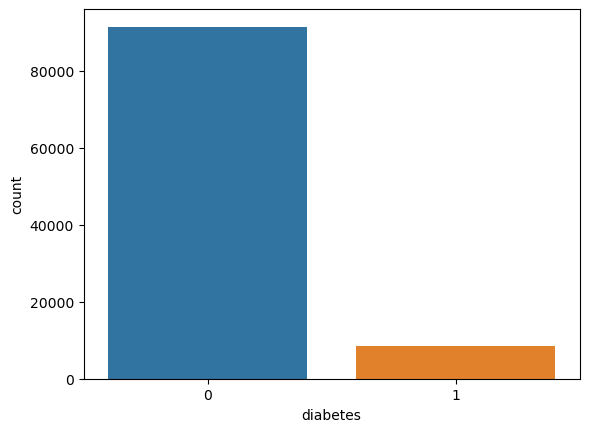

In [14]:
sns.countplot(data=df, x="diabetes")


#### Bivariate exploration

/var/folders/72/sfv07sqs6yx02sknhjkgfkcm0000gn/T/ipykernel_18258/2132396186.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


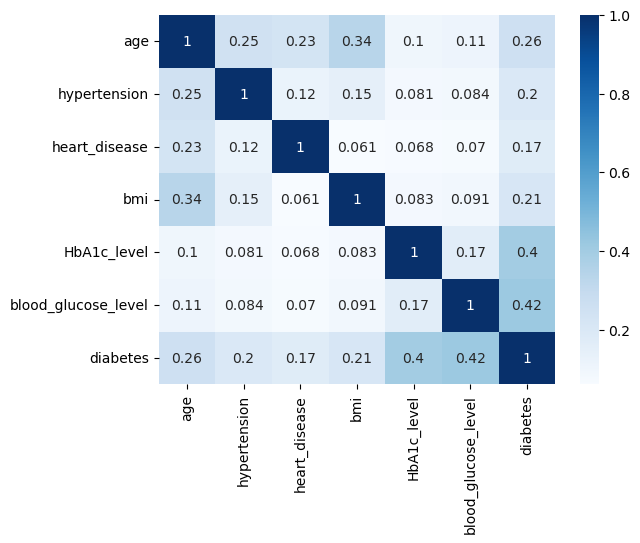

In [15]:
# compute the correlation matrix
corr_matrix = df.corr()

# plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.show()


### Cross-Validation 

### Identifying Outlier

In [16]:
# # Identify Outlier using boxplot
# # Values/attributes should be encoded first (?) // a
# plt.figure(figsize=(15,10))
# for i,col in enumerate(df.columns,1):
#     plt.subplot(4,3,i)
#     plt.title(f"Distribution of {col} Data")
#     sns.boxplot(df[col])
#     plt.tight_layout()
#     plt.plot()


# Preprocessing

## Baseline

In [17]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict

In [37]:
numeric_features = [
    "age",
    "hypertension",
    "heart_disease",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("balancing", RandomOverSampler()),
        ("estimator", DecisionTreeClassifier(max_depth=7, random_state=42)),
    ]
)

# Prepare data
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Prepare target labels
labeler = LabelEncoder()
labeler.fit(y)
y = labeler.transform(y)
label_names = ["Negative", "Positive"]
label_order = [0, 1]

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [19]:
df["gender"].value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

In [20]:
# Encode gender

label_encoder = preprocessing.LabelEncoder()
df["gender"] = label_encoder.fit_transform(df["gender"])
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,No Info,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0


## Normalising the data

# Models

In [21]:
def run_baseline(estimator, X_train, X_test, y_train, y_test):
    # Train and predict
    pipeline.set_params(estimator=estimator)
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)

    # Compute metrics
    cm = confusion_matrix(y_test, prediction, labels=label_order)

    # Plot
    plot_confusion_matrix(cm, classes=label_names, title=type(estimator).__name__)
    plt.show()
    print(classification_report(y_test, prediction, target_names=label_names))

###  Decision Tree

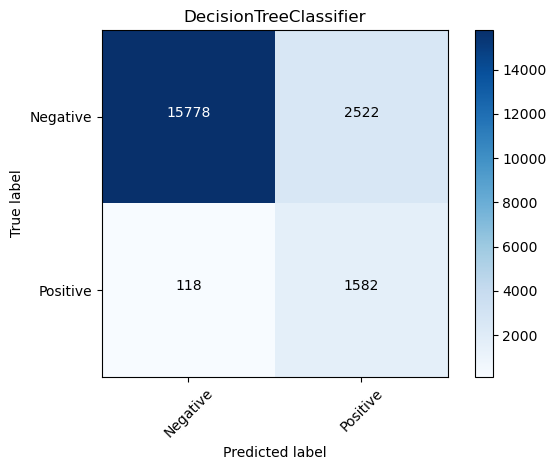

              precision    recall  f1-score   support

    Negative       0.99      0.86      0.92     18300
    Positive       0.39      0.93      0.55      1700

    accuracy                           0.87     20000
   macro avg       0.69      0.90      0.73     20000
weighted avg       0.94      0.87      0.89     20000



In [22]:
estimator = DecisionTreeClassifier(max_depth=7, random_state=42)
run_baseline(estimator, X_train, X_test, y_train, y_test)


#### Plot decision tree

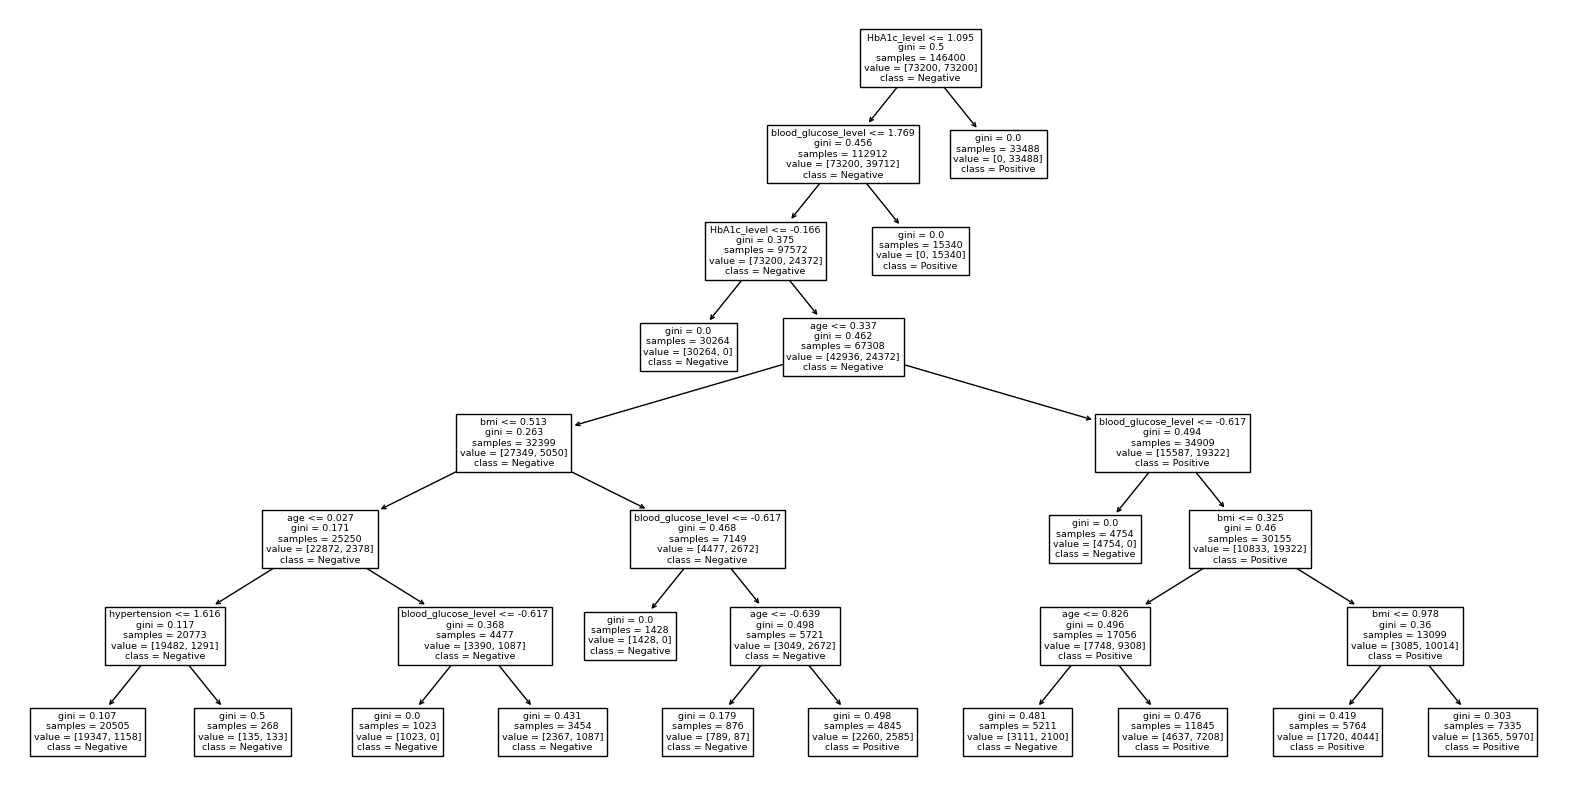

In [23]:
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(estimator, feature_names=numeric_features, class_names=label_names)

plt.savefig("decision_tree.svg", dpi=350, format="svg")
plt.show()


#### Optimize hyperparameters

### Random Forest

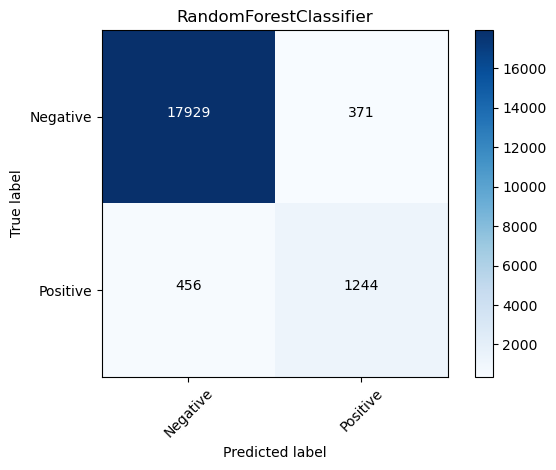

              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98     18300
    Positive       0.77      0.73      0.75      1700

    accuracy                           0.96     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.96      0.96      0.96     20000



In [24]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100, random_state=42)
run_baseline(estimator, X_train, X_test, y_train, y_test)


### K Nearest Neighbors

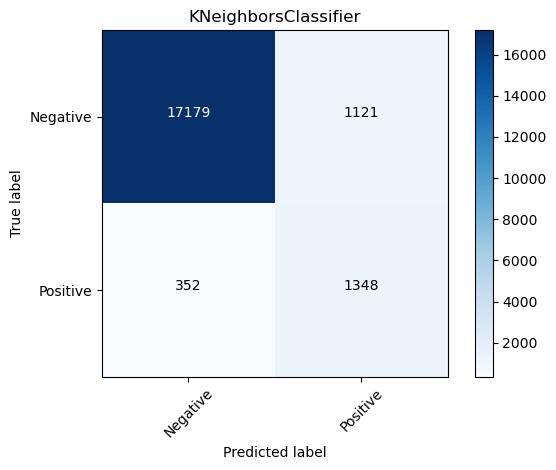

              precision    recall  f1-score   support

    Negative       0.98      0.94      0.96     18300
    Positive       0.55      0.79      0.65      1700

    accuracy                           0.93     20000
   macro avg       0.76      0.87      0.80     20000
weighted avg       0.94      0.93      0.93     20000



In [25]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=5)
run_baseline(estimator, X_train, X_test, y_train, y_test)


### Naive Bayes

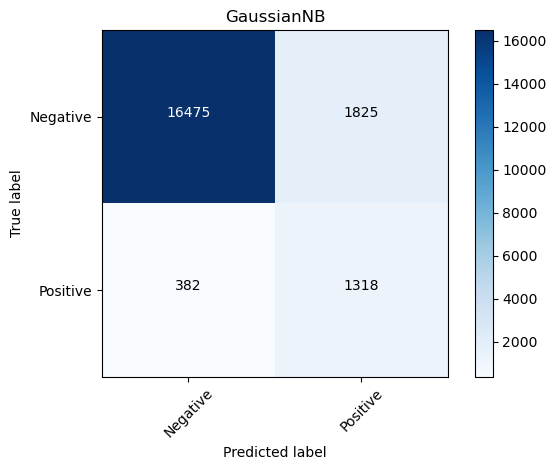

              precision    recall  f1-score   support

    Negative       0.98      0.90      0.94     18300
    Positive       0.42      0.78      0.54      1700

    accuracy                           0.89     20000
   macro avg       0.70      0.84      0.74     20000
weighted avg       0.93      0.89      0.90     20000



In [26]:
from sklearn.naive_bayes import GaussianNB

estimator = GaussianNB()
run_baseline(estimator, X_train, X_test, y_train, y_test)


### Support Vector Machines

In [27]:
# from sklearn.svm import SVC

# estimator = SVC()
# run_baseline(estimator, X_train, X_test, y_train, y_test)


### Neural Network

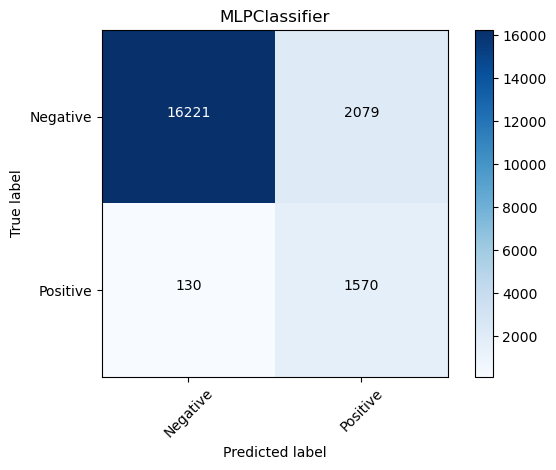

              precision    recall  f1-score   support

    Negative       0.99      0.89      0.94     18300
    Positive       0.43      0.92      0.59      1700

    accuracy                           0.89     20000
   macro avg       0.71      0.90      0.76     20000
weighted avg       0.94      0.89      0.91     20000



In [28]:
from sklearn.neural_network import MLPClassifier

estimator = MLPClassifier()
run_baseline(estimator, X_train, X_test, y_train, y_test)


### FastAI Neural Network

In [29]:
# Fixes the issue with the progress bar in Jupyter notebooks
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch

In [30]:
from fastai.tabular.all import *
from pathlib import Path

path = Path(".")

# Define your categorical and continuous variables
cat_vars = ["gender", "hypertension", "heart_disease"]
cont_vars = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
y_names = "diabetes"
y_block = CategoryBlock()

# Define the preprocessing steps
procs = [Categorify, FillMissing, Normalize]

# Create a TabularDataLoaders object
dls = TabularDataLoaders.from_csv(
    path / "diabetes_prediction_dataset.csv",
    path=path,
    y_names=y_names,
    cat_names=cat_vars,
    cont_names=cont_vars,
    procs=procs,
    bs=2048,
    y_block=y_block,
)

# Learn the model
learn = tabular_learner(dls, metrics=F1Score(average="macro"), y_range=(0, 1))
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,f1_score,time
0,0.654349,0.628820,0.615470,00:01
1,0.585499,0.493309,0.707446,00:01
2,0.513162,0.420288,0.791540,00:01
3,0.450875,0.375458,0.863226,00:01
4,0.405887,0.361085,0.875854,00:01
5,0.379613,0.358090,0.872371,00:01
6,0.365080,0.351267,0.880966,00:01
7,0.357046,0.350658,0.882802,00:01
8,0.352854,0.350230,0.882042,00:00
9,0.350846,0.350052,0.882119,00:01


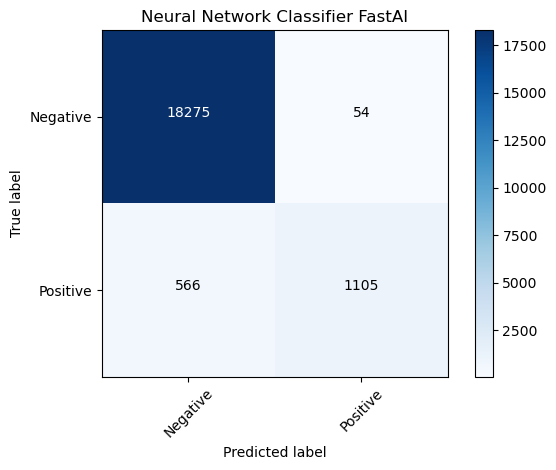

In [31]:
# Get predictions
preds, targets = learn.get_preds(dl=dls.valid)
predicted_classes = preds.argmax(dim=1)

# Plot confusion matrix
cm = confusion_matrix(targets, predicted_classes, labels=label_order)
plot_confusion_matrix(cm, classes=label_names, title="Neural Network Classifier FastAI")
plt.show()


In [32]:
# Report metrics
print(classification_report(targets, predicted_classes))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18329
           1       0.95      0.66      0.78      1671

    accuracy                           0.97     20000
   macro avg       0.96      0.83      0.88     20000
weighted avg       0.97      0.97      0.97     20000



### Logistic Regression

we could try: https://www.kaggle.com/code/anubhav012/diabetes-prediction-eda-model-score-0-9724?scriptVersionId=128635440&cellId=52 

try to adjust parameter to: newton-cholesky (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and penalty to L2 (all features relevant to prediction)

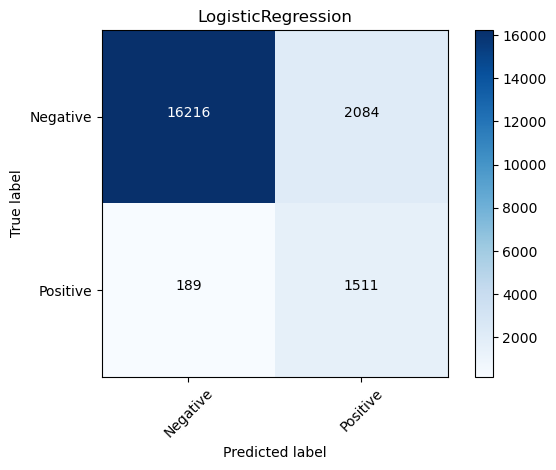

              precision    recall  f1-score   support

    Negative       0.99      0.89      0.93     18300
    Positive       0.42      0.89      0.57      1700

    accuracy                           0.89     20000
   macro avg       0.70      0.89      0.75     20000
weighted avg       0.94      0.89      0.90     20000



In [33]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
run_baseline(estimator, X_train, X_test, y_train, y_test)

# acc = roc_auc_score(y_train, y_test)
# print("ROC AUC Score : ", acc)

### Gradient Boosting Classifier

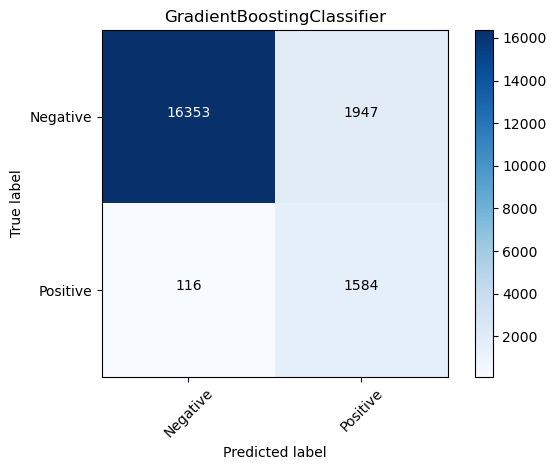

              precision    recall  f1-score   support

    Negative       0.99      0.89      0.94     18300
    Positive       0.45      0.93      0.61      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.91      0.77     20000
weighted avg       0.95      0.90      0.91     20000



In [34]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
run_baseline(estimator, X_train, X_test, y_train, y_test)


### Stratified Cross-Validation

### Optimize Preprossecing

In [59]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV


numeric_features = [
    "age",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
]

nominal_features = [
    "hypertension",
    "heart_disease",
    "gender",
]

ordinal_features = [
    "smoking_history",
]

estimators = [
    {"estimator": KNeighborsClassifier(), "parameters": {'n_neighbors': [3, 5, 7, 9, 11]}},
    {"estimator": LogisticRegression(), "parameters": {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.1, 1, 10, 100]}},
    {"estimator": DecisionTreeClassifier(), "parameters":  {'max_depth': [3, 5, 7, 9, 11]}},
]

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
}

for estimator in estimators:
    for scaler in scalers.values():
        parameters = estimator["parameters"]
        estimator = estimator["estimator"]

        column_encoder = ColumnTransformer(
            transformers=[
                ("nom", OneHotEncoder(), nominal_features),
                ("ord", OrdinalEncoder(), ordinal_features),
                ("num", "passthrough", numeric_features),
            ]
        )

        column_scaler = ColumnTransformer(
            transformers=[
                ("num", scaler, numeric_features),
                # ("nom", scaler, nominal_features),
                # ("ord", scaler, ordinal_features),
            ], remainder='passthrough'
        )

        pipeline = Pipeline(
            [
                ("encoder", column_encoder),
                # ("scaler", column_scaler),
                ("balancing", RandomOverSampler()),
                ("estimator", estimator),
            ]
        )

        # Grid search for best hyper-parameters
        grid_search_estimator = GridSearchCV(pipeline, parameters, cv=5, scoring="f1_macro")
        grid_search_estimator.fit(X, y)
        
        # pipeline.fit(X_train, y_train)

        print(f"Estimator: {estimator}, parameters: {parameters}, Scaler: {scaler}")

        # prediction = pipeline.predict(X_test)

        # Compute metrics
        # cm = confusion_matrix(y_test, prediction, labels=label_order)

        # Plot
        print(classification_report(y_test, prediction, target_names=label_names))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/72/sfv07sqs6yx02sknhjkgfkcm0000gn/T/ipykernel_18258/572661776.py", line 84, in <module>
    grid_search_estimator.fit(X, y)
  File "/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 875, in fit
  File "/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 1379, in _run_search
    verbose=verbose,
  File "/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 822, in evaluate_candidates
    delayed(_fit_and_score)(
  File "/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/jonas/mambaforg

# Evaluation

### Confusion Matrix

### ROC Curve + AUC

### Cost-based Evaluation

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=63e6862b-29c2-46b1-b5dc-6c3d07e3ad13' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>